# Predict Ozone Level

KC1 Software defect prediction
One of the NASA Metrics Data Program defect data sets. Data from software for storage management for receiving and processing ground data. Data comes from McCabe and Halstead features extractors of source code. These features were defined in the 70s in an attempt to objectively characterize code features that are associated with software quality.



## Dataset Description

## Atributes

- loc : numeric % McCabe's line count of code
- v(g) : numeric % McCabe "cyclomatic complexity"
- ev(g) : numeric % McCabe "essential complexity"
- iv(g) : numeric % McCabe "design complexity"
- n : numeric % Halstead total operators + operands
- v : numeric % Halstead "volume"
- l : numeric % Halstead "program length"
- d : numeric % Halstead "difficulty"
- i : numeric % Halstead "intelligence"
- e : numeric % Halstead "effort"
- b : numeric % Halstead
- t : numeric % Halstead's time estimator
- lOCode : numeric % Halstead's line count
- lOComment : numeric % Halstead's count of lines of comments
- lOBlank : numeric % Halstead's count of blank lines
- lOCodeAndComment: numeric
- uniq_Op : numeric % unique operators
- uniq_Opnd : numeric % unique operands
- total_Op : numeric % total operators
- total_Opnd : numeric % total operands
- branchCount : numeric % of the flow graph
- problems : {false,true} % module has/has not one or more reported defects 


The goal is to define the defects class, that has 2 possbible values (1,2).

## Imports

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from openml import tasks, runs, datasets, config
import pandas as pd
from scipy import stats
import numpy as np


## Data Preprocessing

### Fetching the task and dataset

In [2]:
# OpenML configuration
config.apikey = '06194f53581be5f8b8f34a644938ac1e'


# Fetch the task and dataset
task = tasks.get_task(3913)
dataset = task.get_dataset()
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format="dataframe")

In [3]:
X.head()


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,1.30,2.0,2,2,2,1.2,1.2,1.2,1.2,1.4
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1.00,1.0,1,1,1,1.0,1.0,1.0,1.0,1.0
2,415.0,59.0,50.0,51.0,1159.0,8411.31,0.01,103.53,81.24,870848.58,...,48380.48,359.0,35,9,10,47.0,106.0,692.0,467.0,106.0
3,230.0,33.0,10.0,16.0,575.0,3732.82,0.03,39.82,93.74,148644.06,...,8258.00,174.0,15,34,5,23.0,67.0,343.0,232.0,65.0
4,175.0,26.0,12.0,13.0,500.0,3123.96,0.03,29.48,105.96,92103.07,...,5116.84,142.0,7,19,4,18.0,58.0,310.0,190.0,51.0


In [4]:
X.describe()


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,5.220000e+02,...,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,36.894828,4.893487,2.447126,3.650192,94.630843,555.472644,0.274464,9.735287,28.320441,1.854299e+04,...,1094.811456,27.772031,2.000000,4.339080,0.281609,9.197701,14.465900,57.611494,37.023372,8.765134
std,77.944048,10.976772,6.665003,8.054860,233.230165,1817.468320,0.275609,11.088640,32.225597,1.132712e+05,...,7556.521581,64.431485,5.582052,9.214753,1.038236,6.360180,22.086661,142.990741,90.398620,21.942779
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,4.000000,1.000000,1.000000,1.000000,5.000000,11.610000,0.060000,1.500000,7.740000,1.741000e+01,...,0.970000,2.000000,0.000000,0.000000,0.000000,3.000000,2.000000,4.000000,2.000000,1.000000
50%,13.000000,2.000000,1.000000,2.000000,27.000000,109.205000,0.140000,6.000000,20.560000,6.135900e+02,...,34.090000,8.000000,0.000000,1.000000,0.000000,8.000000,7.000000,16.500000,11.000000,3.000000
75%,45.000000,5.000000,1.000000,4.000000,104.750000,543.787500,0.500000,14.610000,38.365000,7.624085e+03,...,423.562500,33.750000,2.000000,5.000000,0.000000,14.000000,20.000000,64.000000,41.000000,9.000000
max,1275.000000,180.000000,125.000000,143.000000,3982.000000,33814.560000,2.000000,103.530000,415.060000,2.147484e+06,...,153047.010000,1107.000000,44.000000,121.000000,11.000000,47.000000,325.000000,2469.000000,1513.000000,361.000000


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loc               522 non-null    float64
 1   v(g)              522 non-null    float64
 2   ev(g)             522 non-null    float64
 3   iv(g)             522 non-null    float64
 4   n                 522 non-null    float64
 5   v                 522 non-null    float64
 6   l                 522 non-null    float64
 7   d                 522 non-null    float64
 8   i                 522 non-null    float64
 9   e                 522 non-null    float64
 10  b                 522 non-null    float64
 11  t                 522 non-null    float64
 12  lOCode            522 non-null    float64
 13  lOComment         522 non-null    uint8  
 14  lOBlank           522 non-null    uint8  
 15  lOCodeAndComment  522 non-null    uint8  
 16  uniq_Op           522 non-null    float64
 1

In [6]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 522 entries, 0 to 521
Series name: problems
Non-Null Count  Dtype   
--------------  -----   
522 non-null    category
dtypes: category(1)
memory usage: 778.0 bytes


In [7]:
X.isnull().sum()

loc                 0
v(g)                0
ev(g)               0
iv(g)               0
n                   0
v                   0
l                   0
d                   0
i                   0
e                   0
b                   0
t                   0
lOCode              0
lOComment           0
lOBlank             0
lOCodeAndComment    0
uniq_Op             0
uniq_Opnd           0
total_Op            0
total_Opnd          0
branchCount         0
dtype: int64

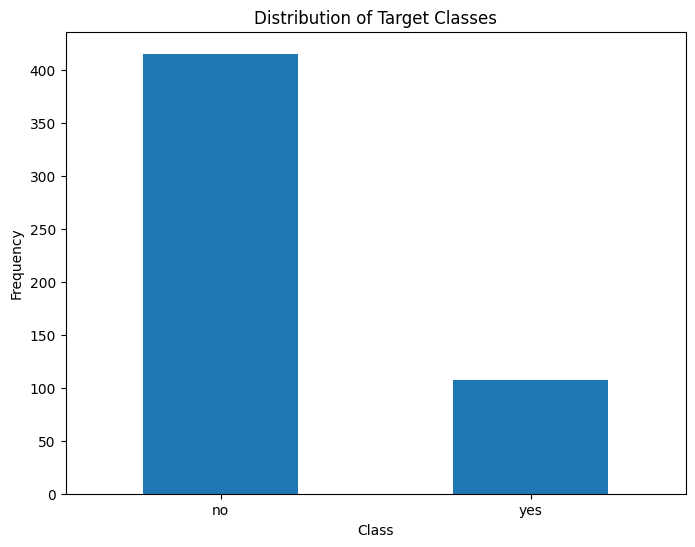

In [8]:
import matplotlib.pyplot as plt


# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
y.value_counts().plot(kind='bar')
plt.title('Distribution of Target Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [9]:
# Identify categorical columns
categorical_columns = list(X.select_dtypes(include=['category']).columns)

# Identify numerical columns
numerical_columns = list(X.select_dtypes(include=['int64', 'float64','uint8']).columns)

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: []
Numerical columns: ['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'lOCodeAndComment', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']


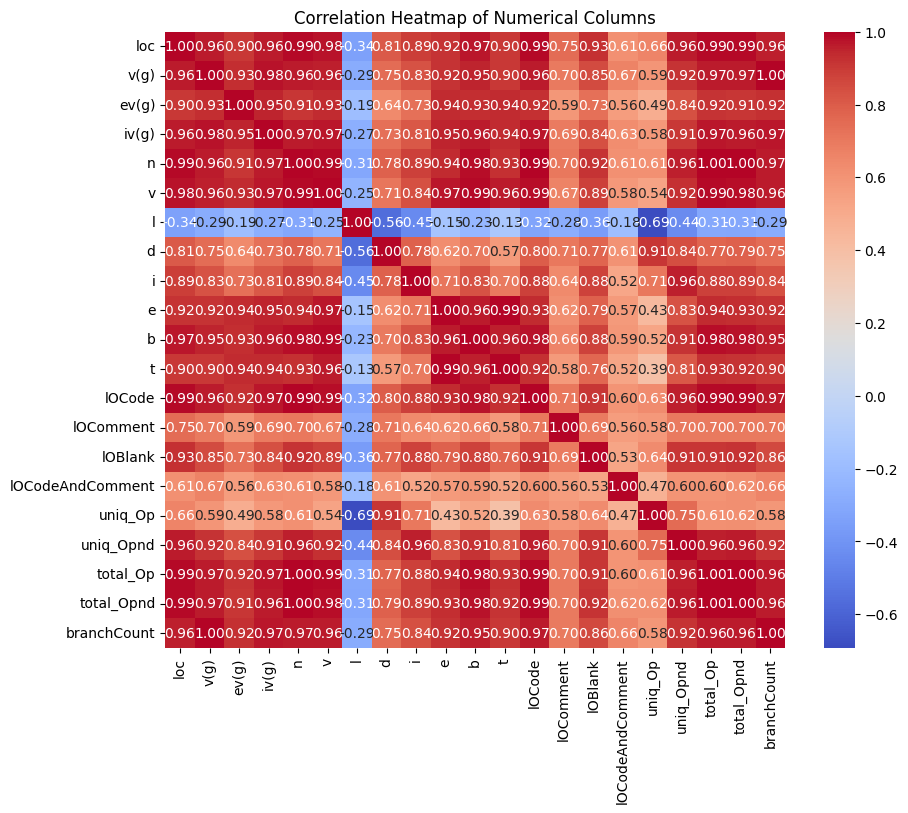

In [34]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = X[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

In [41]:


# Calculate Z-scores for numerical columns
z_scores = np.abs(stats.zscore(X[numerical_columns]))

# Identify outliers (Z-score > 3)
outliers = (z_scores > 3).any(axis=1)

# Calculate the total number of entries
total_entries = X.shape[0]

# Calculate the number of outliers
num_outliers = outliers.sum()

# Calculate the percentage of outliers
percentage_outliers = (num_outliers / total_entries) * 100

# Print the number of outliers and the percentage
print(f"Number of outliers: {num_outliers}")
print(f"Total number of entries: {total_entries}")
print(f"Percentage of outliers: {percentage_outliers:.2f}%")

KeyError: "None of [Index(['PC1', 'PC2', 'PC3', 'PC4'], dtype='object')] are in the [columns]"

In [12]:
from sklearn.svm import OneClassSVM

# Define the One-Class SVM model
ocsvm = OneClassSVM(gamma=0.1, nu=0.05)

# Fit the model to the data
ocsvm.fit(X)

# Predict the outliers
predictions = ocsvm.predict(X)

print(predictions)

# Filter the inliers (non-outliers)
X_inliers = X[predictions == 1]
y_inliers = y[predictions == 1]

# Print the shape of the original and filtered data
print(f"Original data shape: {X.shape}")
print(f"Filtered data shape: {X_inliers.shape}")
print(f"Filtered target shape: {y_inliers.shape}")

[-1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1
  1  1 -1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1 -1  1 -1  1 -1 -1  1  1 -1 -1 -1
  1  1 -1  1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1
 -1  1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1
 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1
 -1 -1  1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1

In [ ]:
from sklearn.svm import OneClassSVM

# Identify categorical columns
categorical_columns = list(X.select_dtypes(include=['category']).columns)

# Identify numerical columns
numerical_columns = list(X.select_dtypes(include=['int64', 'float64','uint8']).columns)



# Define the pipeline
pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_columns),
            ('cat', OneHotEncoder(), categorical_columns)
        ],
        remainder='passthrough'
    )),
    ('classification', SVC(random_state=42))
])

param_grid = {
    'classification__C': [0.1, 1, 5,10],
    'classification__kernel': ['linear', 'rbf', 'poly'],
    'classification__gamma': ['scale', 'auto']
}

# Define the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

print("Best Parameters:", grid_search.best_params_)

model = grid_search.fit(X, y)

# Predict the target variable
y_pred = grid_search.predict(X)

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred)

print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y, y_pred)

# Print the classification report
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

               PC1          PC2          PC3         PC4
0    -18580.036224   133.646335  -278.405511  -14.748044
1    -18580.361961   133.388937  -278.871534  -15.510328
2    853586.605535 -9265.482208 -5337.759051  187.415805
3    130324.777702 -1450.227290  1210.242942    8.413095
4     73697.130351  -840.702106  1476.276439   -2.993183
..             ...          ...          ...         ...
517  -18557.994894   132.194824  -267.454345  -11.384494
518  -18569.289214   132.301988  -271.096270  -11.902823
519  -18569.289214   132.301988  -271.096270  -11.902823
520  -18563.812557   132.255191  -267.305084  -11.236917
521  -18581.441325   132.450015  -279.857647  -15.330136

[522 rows x 4 columns]


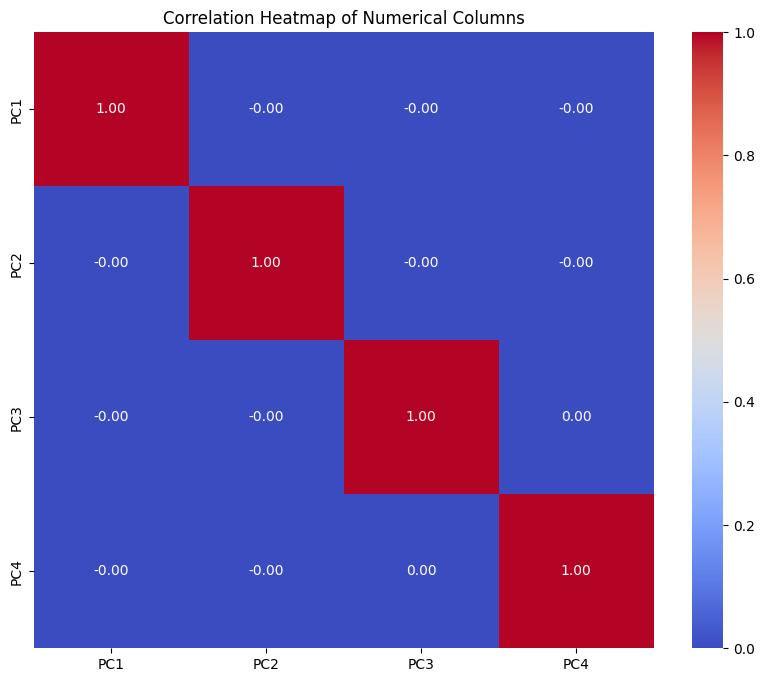

In [36]:
from sklearn.decomposition import PCA


pca_model = PCA(n_components=4)

# Fit the PCA model to the data
pca_model.fit(X)

# Transform the data
pca_data = pca_model.transform(X)


pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
print(pca_df)


# Calculate the correlation matrix
correlation_matrix = pca_df.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END classification__C=0.1, classification__gamma=scale, classification__kernel=linear; total time=   0.1s
[CV] END classification__C=0.1, classification__gamma=scale, classification__kernel=linear; total time=   0.1s
[CV] END classification__C=0.1, classification__gamma=scale, classification__kernel=linear; total time=   0.1s
[CV] END classification__C=0.1, classification__gamma=scale, classification__kernel=linear; total time=   0.0s
[CV] END classification__C=0.1, classification__gamma=scale, classification__kernel=linear; total time=   0.1s
[CV] END classification__C=0.1, classification__gamma=scale, classification__kernel=rbf; total time=   0.0s
[CV] END classification__C=0.1, classification__gamma=scale, classification__kernel=rbf; total time=   0.0s
[CV] END classification__C=0.1, classification__gamma=scale, classification__kernel=rbf; total time=   0.0s
[CV] END classification__C=0.1, classification__gamma=scale,

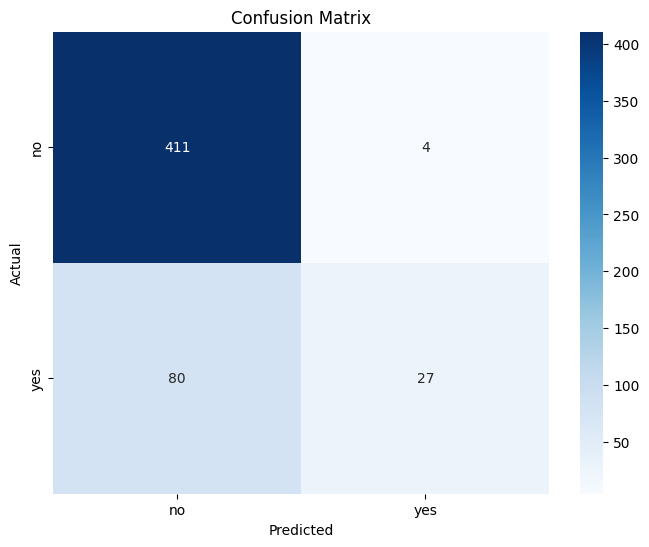

In [40]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Identify categorical columns
categorical_columns = list(pca_df.select_dtypes(include=['category']).columns)

# Identify numerical columns
numerical_columns = list(pca_df.select_dtypes(include=['int64', 'float64','uint8']).columns)


# Define the pipeline
pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_columns),
            ('cat', OneHotEncoder(), categorical_columns)
        ],
        remainder='passthrough'
    )),
    ('classification', SVC(random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'classification__C': [0.1, 1, 5],
    'classification__kernel': ['linear', 'rbf', 'poly'],
    'classification__gamma': ['scale', 'auto'],
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_df, y, test_size=0.2, random_state=42)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict the target variable using the best model
y_pred = best_model.predict(pca_df)

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.2f}")

# Print the classification report
report = classification_report(y, y_pred)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.named_steps['classification'].classes_, yticklabels=best_model.named_steps['classification'].classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


